In [1]:
import pandas as pd
import re
import numpy as np

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv("data.csv")

In [3]:
data.columns = map(str.lower, data.columns)
data.head()

,song,artist names,hot100 ranking year,hot100 rank,lyrics
0,Prisoner of Love - Remastered - 1992,['perry como'],1946,1,"['someone', 'that', 'i', 'belong', 'to', 'does..."
1,To Each His Own,['eddy howard'],1946,2,"['a', 'rose', 'must', 'remain', 'with', 'the',..."
2,The Gypsy,['the ink spots'],1946,3,"['in', 'a', 'quaint', 'caravan', 'theres', 'a'..."
3,Five Minutes More,['frank sinatra'],1946,4,"['dear', 'this', 'evening', 'seemed', 'to', 'g..."
4,Rumors Are Flying,['frankie carle'],1946,5,"['rumors', 'are', 'flying', 'that', 'youve', '..."


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6879 entries, 0 to 6878
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   song                 6879 non-null   object
 1   artist names         6879 non-null   object
 2   hot100 ranking year  6879 non-null   int64 
 3   hot100 rank          6879 non-null   int64 
 4   lyrics               6032 non-null   object
dtypes: int64(2), object(3)
memory usage: 268.8+ KB


In [5]:
data[data['lyrics'].isna()]

,song,artist names,hot100 ranking year,hot100 rank,lyrics
5,Oh! What It Seemed to Be,['frankie carle his piano orchestra'],1946,6,NaN
13,To Each His Own,['freddy martin his orchestra'],1946,14,NaN
14,Ole Buttermilk Sky,['kay kyser his orchestra'],1946,15,NaN
17,The Old Lamplighter,['sammy kaye his orchestra'],1946,18,NaN
20,"Jocelyn, Op. 100: Berceuse (Arr. For vocal, vi...","['benjamin godard', 'bing crosby', 'jascha hei...",1946,20,NaN
...,...,...,...,...,...
6706,Dakiti (Originally Performed by Bad Bunny & Jh...,['backing business'],2021,28,NaN
6725,Wants & Needs,['homixide gang'],2021,47,NaN
6798,Yo Me Porto Bonito,['bad bunn'],2022,20,NaN
6811,Jimmy Cooks - Lofi Cover,"['covers unplugged', 'wild issues']",2022,33,NaN


In [6]:
data = data.dropna(subset=['lyrics'])
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6032 entries, 0 to 6878
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   song                 6032 non-null   object
 1   artist names         6032 non-null   object
 2   hot100 ranking year  6032 non-null   int64 
 3   hot100 rank          6032 non-null   int64 
 4   lyrics               6032 non-null   object
dtypes: int64(2), object(3)
memory usage: 282.8+ KB


In [7]:
data = data.rename(columns={'hot100 ranking year': 'year'})
data = data.rename(columns={'hot100 rank': 'rank'})
data = data.rename(columns={'artist names': 'artist'})

In [8]:
data.head()

,song,artist,year,rank,lyrics
0,Prisoner of Love - Remastered - 1992,['perry como'],1946,1,"['someone', 'that', 'i', 'belong', 'to', 'does..."
1,To Each His Own,['eddy howard'],1946,2,"['a', 'rose', 'must', 'remain', 'with', 'the',..."
2,The Gypsy,['the ink spots'],1946,3,"['in', 'a', 'quaint', 'caravan', 'theres', 'a'..."
3,Five Minutes More,['frank sinatra'],1946,4,"['dear', 'this', 'evening', 'seemed', 'to', 'g..."
4,Rumors Are Flying,['frankie carle'],1946,5,"['rumors', 'are', 'flying', 'that', 'youve', '..."


In [17]:
# Preprocessing
def preprocess_text(text):
    # remove special character and digit|
    text = re.sub(r'\W', " ", text)
    text = re.sub(r'\d+',"", text)
    # convert to lowercase
    text = text.lower()
    return text

data['cleaned lyrics']= data['lyrics'].apply(preprocess_text)

In [18]:
data.head()

,song,artist,year,rank,lyrics,cleaned lyrics,tokenized lyrics,processed lyrics,cluster
0,Prisoner of Love - Remastered - 1992,['perry como'],1946,1,"['someone', 'that', 'i', 'belong', 'to', 'does...",someone that i belong to does...,"[belong, doesnt, belong, faithful, knows, wond...",belong doesnt belong faithful knows wonder wro...,2
1,To Each His Own,['eddy howard'],1946,2,"['a', 'rose', 'must', 'remain', 'with', 'the',...",a rose must remain with the ...,"[rose, remain, sun, rain, lovely, promise, com...",rose remain sun rain lovely promise come true ...,1
2,The Gypsy,['the ink spots'],1946,3,"['in', 'a', 'quaint', 'caravan', 'theres', 'a'...",in a quaint caravan theres a ...,"[quaint, caravan, theres, lady, call, gypsy, l...",quaint caravan theres lady call gypsy look fut...,1
3,Five Minutes More,['frank sinatra'],1946,4,"['dear', 'this', 'evening', 'seemed', 'to', 'g...",dear this evening seemed to g...,"[dear, evening, fast, fun, home, last, look, f...",dear evening fast fun home last look forward k...,1
4,Rumors Are Flying,['frankie carle'],1946,5,"['rumors', 'are', 'flying', 'that', 'youve', '...",rumors are flying that youve ...,"[rumors, flying, youve, sighing, crazy, kind, ...",rumors flying youve sighing crazy kind daze la...,1


In [19]:
#tokenization and stopword removal
stop_words = set(stopwords.words('english'))

new = {"dont","im","youre","lil","ill","bout","pull","yeah","gonna","aint","ive", "youll","wont","woo","yay","like","got","nah","ah","get","na","like",'que', 'pero', 'con', 'por', 'est', 'noche', 'hace', 'tiempo', 'esta', 'todo', 'una', 'voa', 'dime', 'hoy', 'estoy', 'vamo', 'quieres', 'mami', 'ests', 'eres',"ooh" }
stop_words.update(new)
words_and_phrases = {
    'x', 'y', 'your', 'yours', 'yourself', 'yourselves', 'you', 'yond', 'yonder', 'yon', 'ye', 'yet', 'z', 'zillion', 'j', 'u', 'umpteen', 'usually', 'us', 'username', 'uponed', 'upons', 'uponing', 'upon', 'ups', 'upping', 'upped', 'up', 'unto', 'until', 'unless', 'unlike', 'unliker', 'unlikest', 'under', 'underneath', 'use', 'used', 'usedest', 'r', 'rath', 'rather', 'rathest', 'rathe', 're', 'relate', 'related', 'relatively', 'regarding', 'really', 'res', 'respecting', 'respectively', 'q', 'quite', 'que', 'qua', 'n', 'neither', 'neaths', 'neath', 'nethe', 'nethermost', 'necessary', 'necessariest', 'necessarier', 'never', 'nevertheless', 'nigh', 'nighest', 'nigher', 'nine', 'noone', 'nobody', 'nobodies', 'nowhere', 'nowheres', 'no', 'noes', 'nor', 'nos', 'no-one', 'none', 'not', 'notwithstanding', 'nothings', 'nothing', 'nathless', 'natheless', 't', 'ten', 'tills', 'till', 'tilled', 'tilling', 'to', 'towards', 'toward', 'towardest', 'towarder', 'together', 'too', 'thy', 'thyself', 'thus', 'than', 'that', 'those', 'thou', 'though', 'thous', 'thouses', 'thoroughest', 'thorougher', 'thorough', 'thoroughly', 'thru', 'thruer', 'thruest', 'thro', 'through', 'throughout', 'throughest', 'througher', 'thine', 'this', 'thises', 'they', 'thee', 'the', 'then', 'thence', 'thenest', 'thener', 'them', 'themselves', 'these', 'therer', 'there', 'thereby', 'therest', 'thereafter', 'therein', 'thereupon', 'therefore', 'their', 'theirs', 'thing', 'things', 'three', 'two', 'o', 'oh', 'owt', 'owning', 'owned', 'own', 'owns', 'others', 'other', 'otherwise', 'otherwisest', 'otherwiser', 'of', 'often', 'oftener', 'oftenest', 'off', 'offs', 'offest', 'one', 'ought', 'oughts', 'our', 'ours', 'ourselves', 'ourself', 'out', 'outest', 'outed', 'outwith', 'outs', 'outside', 'over', 'overallest', 'overaller', 'overalls', 'overall', 'overs', 'or', 'orer', 'orest', 'on', 'oneself', 'onest', 'ons', 'onto', 'a', 'atween', 'at', 'athwart', 'atop', 'afore', 'afterward', 'afterwards', 'after', 'afterest', 'afterer', 'ain', 'an', 'any', 'anything', 'anybody', 'anyone', 'anyhow', 'anywhere', 'anent', 'anear', 'and', 'andor', 'another', 'around', 'ares', 'are', 'aest', 'aer', 'against', 'again', 'accordingly', 'abaft', 'abafter', 'abaftest', 'abovest', 'above', 'abover', 'abouter', 'aboutest', 'about', 'aid', 'amidst', 'amid', 'among', 'amongst', 'apartest', 'aparter', 'apart', 'appeared', 'appears', 'appear', 'appearing', 'appropriating', 'appropriate', 'appropriatest', 'appropriates', 'appropriater', 'appropriated', 'already', 'always', 'also', 'along', 'alongside', 'although', 'almost', 'all', 'allest', 'aller', 'allyou', 'alls', 'albeit', 'awfully', 'as', 'aside', 'asides', 'aslant', 'ases', 'astrider', 'astride', 'astridest', 'astraddlest', 'astraddler', 'astraddle', 'availablest', 'availabler', 'available', 'aughts', 'aught', 'vs', 'v', 'variousest', 'variouser', 'various', 'via', 'vis-a-vis', 'vis-a-viser', 'vis-a-visest', 'viz', 'very', 'veriest', 'verier', 'versus', 'n', 'neither', 'neaths', 'neath', 'nethe', 'nethermost', 'necessary', 'necessariest', 'necessarier', 'never', 'nevertheless', 'nigh', 'nighest', 'nigher', 'nine', 'noone', 'nobody', 'nobodies', 'nowhere', 'nowheres', 'no', 'noes', 'nor', 'nos', 'no-one', 'none', 'not', 'notwithstanding', 'nothings', 'nothing', 'nathless', 'natheless', 't', 'ten', 'tills', 'till', 'tilled', 'tilling', 'to', 'towards', 'toward', 'towardest', 'towarder', 'together', 'too', 'thy', 'thyself', 'thus', 'than', 'that', 'those', 'thou', 'though', 'thous', 'thouses', 'thoroughest', 'thorougher', 'thorough', 'thoroughly', 'thru', 'thruer', 'thruest', 'thro', 'through', 'throughout', 'throughest', 'througher', 'thine', 'this', 'thises', 'they', 'thee', 'the', 'then', 'thence', 'thenest', 'thener', 'them', 'themselves', 'these', 'therer', 'there', 'thereby', 'therest', 'thereafter', 'therein', 'thereupon', 'therefore', 'their', 'theirs', 'thing', 'things', 'three', 'two', 'o', 'oh', 'owt', 'owning', 'owned', 'own', 'owns', 'others', 'other', 'otherwise', 'otherwisest', 'otherwiser', 'of', 'often', 'oftener', 'oftenest', 'off', 'offs', 'offest', 'one', 'ought', 'oughts', 'our', 'ours', 'ourselves', 'ourself', 'out', 'outest', 'outed', 'outwith', 'outs', 'outside', 'over', 'overallest', 'overaller', 'overalls', 'overall', 'overs', 'or', 'orer', 'orest', 'on', 'oneself', 'onest', 'ons', 'onto', 'a', 'atween', 'at', 'athwart', 'atop', 'afore', 'afterward', 'afterwards', 'after', 'afterest', 'afterer', 'ain', 'an', 'any', 'anything', 'anybody', 'anyone', 'anyhow', 'anywhere', 'anent', 'anear', 'and', 'andor', 'another', 'around', 'ares', 'are', 'aest', 'aer', 'against', 'again', 'accordingly', 'abaft', 'abafter', 'abaftest', 'abovest', 'above', 'abover', 'abouter', 'aboutest', 'about', 'aid', 'amidst', 'amid', 'among', 'amongst', 'apartest', 'aparter', 'apart', 'appeared', 'appears', 'appear', 'appearing', 'appropriating', 'appropriate', 'appropriatest', 'appropriates', 'appropriater', 'appropriated', 'already', 'always', 'also', 'along', 'alongside', 'although', 'almost', 'all', 'allest', 'aller', 'allyou', 'alls', 'albeit', 'awfully', 'as', 'aside', 'asides', 'aslant', 'ases', 'astrider', 'astride', 'astridest', 'astraddlest', 'astraddler', 'astraddle', 'availablest', 'availabler', 'available', 'aughts', 'aught', 'vs', 'v', 'variousest', 'variouser', 'various', 'via', 'vis-a-vis', 'vis-a-viser', 'vis-a-visest', 'viz', 'very', 'veriest', 'verier', 'versus', 'v', 'v', 'variousest', 'variouser', 'various', 'via', 'vis-a-vis', 'vis-a-viser', 'vis-a-visest', 'viz', 'very', 'veriest', 'verier', 'versus', 'k', 'g', 'go', 'gone', 'good', 'got', 'gotta', 'gotten', 'get', 'gets', 'getting', 'b', 'by', 'byandby', 'by-and-by', 'bist', 'both', 'but', 'buts', 'be', 'beyond', 'because', 'became', 'becomes', 'become', 'becoming', 'becomings', 'becominger', 'becomingest', 'behind', 'behinds', 'before', 'beforehand', 'beforehandest', 'beforehander', 'bettered', 'betters', 'better', 'bettering', 'betwixt', 'between', 'beneath', 'been', 'below', 'besides', 'beside', 'm', 'my', 'myself', 'mucher', 'muchest', 'much', 'must', 'musts', 'musths', 'musth', 'main', 'make', 'mayest', 'many', 'mauger', 'maugre', 'me', 'meanwhiles', 'meanwhile', 'mostly', 'most', 'moreover', 'more', 'might', 'mights', 'midst', 'midsts', 'h', 'huh', 'humph', 'he', 'hers', 'herself', 'her', 'hereby', 'herein', 'hereafters', 'hereafter', 'hereupon', 'hence', 'hadst', 'had', 'having', 'haves', 'have', 'has', 'hast', 'hardly', 'hae', 'hath', 'him', 'himself', 'hither', 'hitherest', 'hitherer', 'his', 'how-do-you-do', 'however', 'how', 'howbeit', 'howdoyoudo', 'hoos', 'hoo', 'w', 'woulded', 'woulding', 'would', 'woulds', 'was', 'wast', 'we', 'wert', 'were', 'with', 'withal', 'without', 'within', 'why', 'what', 'whatever', 'whateverer', 'whateverest', 'whatsoeverer', 'whatsoeverest', 'whatsoever', 'whence', 'whencesoever', 'whenever', 'whensoever', 'when', 'whenas', 'whether', 'wheen', 'whereto', 'whereupon', 'wherever', 'whereon', 'whereof', 'where', 'whereby', 'wherewithal', 'wherewith', 'whereinto', 'wherein', 'whereafter', 'whereas', 'wheresoever', 'wherefrom', 'which', 'whichever', 'whichsoever', 'whilst', 'while', 'whiles', 'whithersoever', 'whither', 'whoever', 'whosoever', 'whoso', 'whose', 'whomever', 's', 'syne', 'syn', 'shalling', 'shall', 'shalled', 'shalls', 'shoulding', 'should', 'shoulded', 'shoulds', 'she', 'sayyid', 'sayid', 'said', 'saider', 'saidest', 'same', 'samest', 'sames', 'samer', 'saved', 'sans', 'sanses', 'sanserifs', 'sanserif', 'so', 'soer', 'soest', 'sobeit', 'someone', 'somebody', 'somehow', 'some', 'somewhere', 'somewhat', 'something', 'sometimest', 'sometimes', 'sometimer', 'sometime', 'several', 'severaler', 'severalest', 'serious', 'seriousest', 'seriouser', 'senza', 'send', 'sent', 'seem', 'seems', 'seemed', 'seemingest', 'seeminger', 'seemings', 'seven', 'summat', 'sups', 'sup', 'supping', 'supped', 'such', 'since', 'sine', 'sines', 'sith', 'six', 'stop', 'stopped', 'p', 'plaintiff', 'plenty', 'plenties', 'please', 'pleased', 'pleases', 'per', 'perhaps', 'particulars', 'particularly', 'particular', 'particularest', 'particularer', 'pro', 'providing', 'provides', 'provided', 'provide', 'probably', 'l', 'layabout', 'layabouts', 'latter', 'latterest', 'latterer', 'latterly', 'latters', 'lots', 'lotting', 'lotted', 'lot', 'lest', 'less', 'ie', 'ifs', 'if', 'i', 'info', 'information', 'itself', 'its', 'it', 'is', 'idem', 'idemer', 'idemest', 'immediate', 'immediately', 'immediatest', 'immediater', 'in', 'inwards', 'inwardest', 'inwarder', 'inward', 'inasmuch', 'into', 'instead', 'insofar', 'indicates', 'indicated', 'indicate', 'indicating', 'indeed', 'inc', 'f', 'fact', 'facts', 'fs', 'figupon', 'figupons', 'figuponing', 'figuponed', 'few', 'fewer', 'fewest', 'frae', 'from', 'failing', 'failings', 'five', 'furthers', 'furtherer', 'furthered', 'furtherest', 'further', 'furthering', 'furthermore', 'fourscore', 'followthrough', 'for', 'forwhy', 'fornenst', 'formerly', 'former', 'formerer', 'formerest', 'formers', 'forbye', 'forby', 'fore', 'forever', 'forer', 'fores', 'four', 'd', 'ddays', 'dday', 'do', 'doing', 'doings', 'doe', 'does', 'doth', 'downwarder', 'downwardest', 'downward', 'downwards', 'downs', 'done', 'doner', 'dones', 'donest', 'dos', 'dost', 'did', 'differentest', 'differenter', 'different', 'describing', 'describe', 'describes', 'described', 'despiting', 'despites', 'despited', 'despite', 'during', 'c', 'cum', 'circa', 'chez', 'cer', 'certain', 'certainest', 'certainer', 'cest', 'canst', 'cannot', 'cant', 'cants', 'canting', 'cantest', 'canted', 'co', 'could', 'couldst', 'comeon', 'comeons', 'come-ons', 'come-on', 'concerning', 'concerninger', 'concerningest', 'consequently', 'considering', 'e', 'eg', 'eight', 'either', 'even', 'evens', 'evenser', 'evensest', 'evened', 'evenest', 'ever', 'everyone', 'everything', 'everybody', 'everywhere', 'every', 'ere', 'each', 'et', 'etc', 'elsewhere', 'else', 'ex', 'excepted', 'excepts', 'except', 'excepting', 'exes', 'enough'
}

stop_words.update(words_and_phrases)
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return ' '.join(words)

data['cleaned lyrics'] = data['cleaned lyrics'].apply(remove_stopwords)

def tokenize(text):
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return tokens

data['tokenized lyrics']= data['cleaned lyrics'].apply(tokenize)
data['processed lyrics']= data['tokenized lyrics'].apply(lambda x: " ".join(x))

In [20]:

data.head()

,song,artist,year,rank,lyrics,cleaned lyrics,tokenized lyrics,processed lyrics,cluster
0,Prisoner of Love - Remastered - 1992,['perry como'],1946,1,"['someone', 'that', 'i', 'belong', 'to', 'does...",belong doesnt belong faithful knows wonder wro...,"[belong, doesnt, belong, faithful, knows, wond...",belong doesnt belong faithful knows wonder wro...,2
1,To Each His Own,['eddy howard'],1946,2,"['a', 'rose', 'must', 'remain', 'with', 'the',...",rose remain sun rain lovely promise come true ...,"[rose, remain, sun, rain, lovely, promise, com...",rose remain sun rain lovely promise come true ...,1
2,The Gypsy,['the ink spots'],1946,3,"['in', 'a', 'quaint', 'caravan', 'theres', 'a'...",quaint caravan theres lady call gypsy look fut...,"[quaint, caravan, theres, lady, call, gypsy, l...",quaint caravan theres lady call gypsy look fut...,1
3,Five Minutes More,['frank sinatra'],1946,4,"['dear', 'this', 'evening', 'seemed', 'to', 'g...",dear evening fast fun home last look forward k...,"[dear, evening, fast, fun, home, last, look, f...",dear evening fast fun home last look forward k...,1
4,Rumors Are Flying,['frankie carle'],1946,5,"['rumors', 'are', 'flying', 'that', 'youve', '...",rumors flying youve sighing crazy kind daze la...,"[rumors, flying, youve, sighing, crazy, kind, ...",rumors flying youve sighing crazy kind daze la...,1


In [33]:
# feature extraction ( TF-IDF)
vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = vectorizer.fit_transform(data['processed lyrics'])


  (0, 417)	0.21438624290566116
  (0, 463)	0.09626377656958755
  (0, 432)	0.17770870679536946
  (0, 758)	0.20136541430486
  (0, 21)	0.21198326188454916
  (0, 219)	0.13777866780995784
  (0, 721)	0.1316252566113128
  (0, 294)	0.14131543052029244
  (0, 16)	0.14429938272097198
  (0, 944)	0.13198683197356603
  (0, 443)	0.15404458609366528
  (0, 238)	0.2125700698866467
  (0, 953)	0.16917992002369553
  (0, 907)	0.13612528697649848
  (0, 789)	0.14301973237014373
  (0, 493)	0.24163516856911252
  (0, 657)	0.21027475049769673
  (0, 567)	0.0888047302970121
  (0, 120)	0.2176179924446663
  (0, 82)	0.13316727569594314
  (0, 933)	0.20136541430486
  (0, 274)	0.10789887158892289
  (0, 575)	0.18039980486331644
  (0, 10)	0.11801007467720748
  (0, 777)	0.2912462181365966
  :	:
  (6031, 745)	0.22430095725393934
  (6031, 855)	0.19004392532152584
  (6031, 491)	0.05131725706476102
  (6031, 379)	0.15060416953801375
  (6031, 866)	0.05315521722640752
  (6031, 154)	0.1404930515718292
  (6031, 362)	0.052357761883622

In [34]:
# clustering ( KMeans )
num_clusters = 3
kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(tfidf_matrix)
data['cluster'] = kmeans.labels_

In [30]:
#Number of songs per cluster
cluster_counts = data['cluster'].value_counts()
print("Cluster Statistics:")
for i in range(num_clusters):
    print(f"Cluster {i}: Number of Song - {cluster_counts[i]}")

Cluster Statistics:
Cluster 0: Number of Song - 1088
Cluster 1: Number of Song - 1517
Cluster 2: Number of Song - 3427


In [31]:
#Extract top words from each Cluster
top_words_per_cluster = {}
order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(num_clusters):
    top_words = [terms[ind] for ind in order_centroids[i, :20]]
    top_words_per_cluster[f'Cluster {i}']= top_words
    print(top_words)


['baby', 'love', 'know', 'come', 'want', 'cause', 'see', 'let', 'time', 'say']
['love', 'know', 'time', 'say', 'cause', 'want', 'see', 'baby', 'let', 'come']
['know', 'cause', 'time', 'see', 'want', 'say', 'come', 'let', 'love', 'baby']


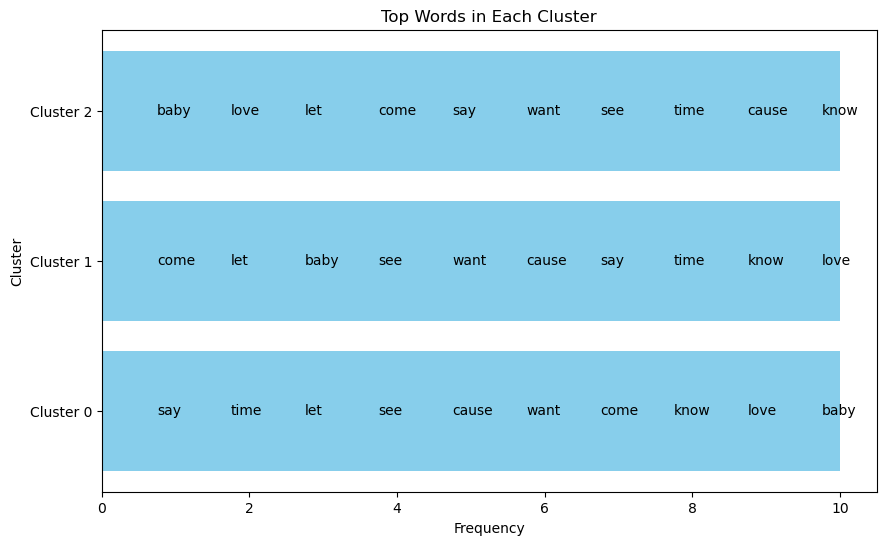

In [32]:
#plotting
plt.figure(figsize=(10, 6))
for cluster, top_words in top_words_per_cluster.items():
    plt.barh(cluster, len(top_words), color='skyblue')
    for index, value in enumerate(top_words):
        plt.text(len(top_words) - index - 0.25, cluster, value, color='black', va='center')
plt.xlabel('Frequency')
plt.ylabel('Cluster')
plt.title('Top Words in Each Cluster')
plt.show()

In [ ]:
data.head()

In [ ]:
print(data['processed lyrics'][6579][0:])
